Please upload your CSV files containing LCA impact data...
Files should have columns: 'Impact category', 'Unit', 'Total'


Saving Basecase_model5_Sheet1.csv to Basecase_model5_Sheet1.csv
Saving temp_30f_Sheet1.csv to temp_30f_Sheet1.csv
Saving temp_32_f_Sheet1.csv to temp_32_f_Sheet1.csv
Saving temp_35f_Sheet1.csv to temp_35f_Sheet1.csv
Loading file: Basecase_model5_Sheet1.csv
Loading file: temp_30f_Sheet1.csv
Loading file: temp_32_f_Sheet1.csv
Loading file: temp_35f_Sheet1.csv


HTML(value='<h2>LCA Sensitivity Analysis Configuration</h2>')

HTML(value='<h3>Select Base Case</h3>')

Dropdown(description='Base Case:', layout=Layout(width='80%'), options=('Basecase_model5_Sheet1.csv', 'temp_30…

HTML(value='<h3>Configure Scenarios</h3>')

HTML(value='<p><i>Note: Colors are automatically assigned from a colorblind-friendly palette</i></p>')

HTML(value='<h3>Select Impact Categories</h3>')

SelectMultiple(description='Impact Categories:', index=(4, 15, 3, 10, 8, 1, 17), layout=Layout(height='200px',…

HTML(value='<h3>Specify which categories have negative=beneficial interpretation</h3>')

Button(button_style='success', description='Create Sensitivity Plot', icon='chart-bar', style=ButtonStyle(), t…

Output()

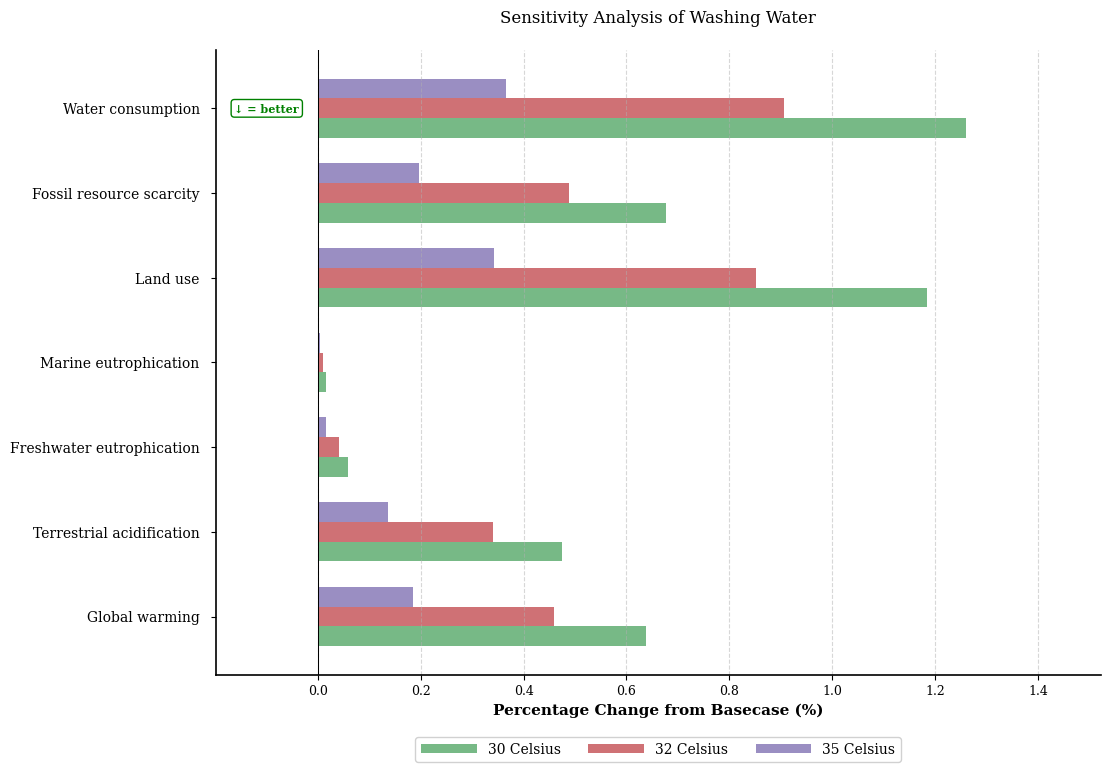

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results saved to: output/lca_sensitivity_results.csv


In [ ]:
# Install required libraries
!pip install matplotlib seaborn pandas numpy ipywidgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import files
import re
import matplotlib
import os

# Configure matplotlib backend properly for Colab
matplotlib.use('Agg')
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

# Configure plot styling
def configure_plot_style():
    plt.rc('xtick', top=False)
    plt.rc('ytick', right=False)
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=9)
    plt.rc('ytick', labelsize=9)
    plt.rc('axes', labelsize=10)
    plt.rc('legend', handlelength=4.0)

    # Set colorblind-friendly palette as default
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
        '#4C72B0', '#55A868', '#C44E52', '#8172B3',
        '#CCB974', '#64B5CD', '#AD8BC9', '#B0724E'
    ])

# Load CSV files for analysis
def load_csv_files():
    """Load CSV files containing LCA impact data"""
    clear_output()
    print("Please upload your CSV files containing LCA impact data...")
    print("Files should have columns: 'Impact category', 'Unit', 'Total'")
    uploaded = files.upload()

    # Process each uploaded file
    scenarios = {}
    filenames = list(uploaded.keys())

    for filename in filenames:
        # Extract default scenario name from filename
        scenario_name = re.sub(r'\.csv$', '', filename)

        # Load the CSV
        print(f"Loading file: {filename}")
        try:
            df = pd.read_csv(filename)

            # Basic validation
            required_columns = ['Impact category', 'Total']
            if not all(col in df.columns for col in required_columns):
                print(f"Warning: File {filename} is missing required columns. Skipping.")
                continue

            # Convert Total to numeric
            df['Total'] = pd.to_numeric(df['Total'], errors='coerce')

            # Drop rows with NaN values in Total
            df = df.dropna(subset=['Total'])

            # Store in scenarios dictionary
            scenarios[filename] = {
                'data': df,
                'display_name': scenario_name,
                'italic': False
            }

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return scenarios

# Define selected impact categories
DEFAULT_CATEGORIES = [
    'Global warming',
    'Terrestrial acidification',
    'Freshwater eutrophication',
    'Marine eutrophication',
    'Land use',
    'Fossil resource scarcity',
    'Water consumption'
]

# Create interactive scenario definition UI
def create_scenario_definition_ui(scenarios):
    """Create interactive widgets for defining LCA scenarios"""
    scenario_widgets = {}

    # Create base case selector
    base_selector = widgets.Dropdown(
        options=list(scenarios.keys()),
        description='Base Case:',
        disabled=False,
        layout=widgets.Layout(width='80%')
    )

    # Define colorblind-friendly palette
    colorblind_palette = [
        '#4C72B0', '#55A868', '#C44E52', '#8172B3',
        '#CCB974', '#64B5CD', '#AD8BC9', '#B0724E'
    ]

    # Create widgets for each scenario
    for i, filename in enumerate(scenarios.keys()):
        name_input = widgets.Text(
            value=scenarios[filename]['display_name'],
            description='Display Name:',
            disabled=False,
            layout=widgets.Layout(width='60%')
        )

        italic_checkbox = widgets.Checkbox(
            value=False,
            description='Italic',
            disabled=False,
            indent=False
        )

        include_checkbox = widgets.Checkbox(
            value=True,
            description='Include in Analysis',
            disabled=False,
            indent=False
        )

        # Assign color from colorblind-friendly palette
        color_picker = widgets.ColorPicker(
            concise=False,
            description='Color:',
            value=colorblind_palette[i % len(colorblind_palette)],
            disabled=False,
            layout=widgets.Layout(width='60%')
        )

        # Store widgets for this scenario
        scenario_widgets[filename] = {
            'name': name_input,
            'italic': italic_checkbox,
            'include': include_checkbox,
            'color': color_picker
        }

    return base_selector, scenario_widgets

# Create UI for impact category configuration
def create_impact_category_ui(scenarios):
    """Create UI for LCA impact category selection and configuration"""
    # Get all unique impact categories
    all_categories = set()
    for scenario_info in scenarios.values():
        df = scenario_info['data']
        all_categories.update(df['Impact category'])

    # Filter default categories to only include those in the data
    available_defaults = [cat for cat in DEFAULT_CATEGORIES if cat in all_categories]

    # Category selector
    category_selector = widgets.SelectMultiple(
        options=sorted(list(all_categories)),
        value=available_defaults,
        description='Impact Categories:',
        disabled=False,
        layout=widgets.Layout(width='80%', height='200px')
    )

    # Create widgets to define which categories have negative=beneficial interpretation
    negative_is_beneficial = {}
    for category in all_categories:
        negative_is_beneficial[category] = widgets.Checkbox(
            value=category.lower() in ['water consumption', 'water use', 'water footprint'],
            description=f'Negative is beneficial',
            disabled=False,
            indent=False
        )

    return category_selector, negative_is_beneficial

# Display scenario configuration UI
def display_scenario_ui(scenarios):
    """Create and display the interactive UI for LCA scenario configuration"""
    base_selector, scenario_widgets = create_scenario_definition_ui(scenarios)
    category_selector, negative_is_beneficial = create_impact_category_ui(scenarios)

    # Create a tab for each scenario
    children = []
    titles = []

    for filename, widgets_dict in scenario_widgets.items():
        scenario_box = widgets.VBox([
            widgets_dict['name'],
            widgets.HBox([widgets_dict['italic'], widgets_dict['include']]),
            widgets_dict['color']
        ])
        children.append(scenario_box)
        titles.append(scenarios[filename]['display_name'])

    # Create tabs for scenarios
    scenario_tabs = widgets.Tab()
    scenario_tabs.children = children
    for i, title in enumerate(titles):
        scenario_tabs.set_title(i, title)

    # Create tabs for negative is beneficial configuration
    negative_children = []
    negative_titles = []

    # Group checkboxes by 5 per tab
    checkbox_groups = []
    current_group = []

    for category, checkbox in negative_is_beneficial.items():
        current_group.append(widgets.HBox([
            widgets.Label(value=category, layout=widgets.Layout(width='200px')),
            checkbox
        ]))

        if len(current_group) >= 5:
            checkbox_groups.append(widgets.VBox(current_group))
            current_group = []

    # Add any remaining checkboxes
    if current_group:
        checkbox_groups.append(widgets.VBox(current_group))

    # Create tabs for groups of checkboxes
    for i, group in enumerate(checkbox_groups):
        negative_children.append(group)
        negative_titles.append(f'Group {i+1}')

    negative_tabs = widgets.Tab()
    negative_tabs.children = negative_children
    for i, title in enumerate(negative_titles):
        negative_tabs.set_title(i, title)

    # Create analyze button
    analyze_button = widgets.Button(
        description='Create Sensitivity Plot',
        disabled=False,
        button_style='success',
        tooltip='Click to generate the plot',
        icon='chart-bar'
    )

    output = widgets.Output()

    # Define what happens when analyze button is clicked
    def on_analyze_button_clicked(b):
        with output:
            clear_output()
            print("Starting LCA sensitivity analysis...")
            try:
                # Update scenario information based on widget values
                for filename, widgets_dict in scenario_widgets.items():
                    scenarios[filename]['display_name'] = widgets_dict['name'].value
                    scenarios[filename]['italic'] = widgets_dict['italic'].value

                # Get base case
                base_file = base_selector.value
                base_name = scenarios[base_file]['display_name']

                # Check if any non-base scenarios are selected
                other_scenarios_selected = False
                for filename, widgets_dict in scenario_widgets.items():
                    if filename != base_file and widgets_dict['include'].value:
                        other_scenarios_selected = True
                        break

                if not other_scenarios_selected:
                    print("Error: Please select at least one scenario to compare with the base case")
                    print("Hint: Make sure at least one scenario (other than the base case) has the 'Include in Analysis' checkbox checked")
                    return

                # Get selected categories
                selected_categories = list(category_selector.value)
                if not selected_categories:
                    print("Error: Please select at least one impact category")
                    return

                # Get negative is beneficial settings
                beneficial_settings = {
                    cat: negative_is_beneficial[cat].value
                    for cat in selected_categories
                }

                # Process scenarios
                changes_df = calculate_changes(
                    scenarios,
                    base_file,
                    selected_categories,
                    scenario_widgets,
                    beneficial_settings
                )

                # Verify that we have scenario columns
                scenario_columns = [col for col in changes_df.columns
                                   if col != 'Impact Category'
                                   and not col.startswith('Impact Category_')
                                   and not col.endswith('_color')
                                   and not col.endswith('_italic')
                                   and not col.endswith('_raw_value')
                                   and not col.endswith('_base_value')
                                   and not col.endswith('_beneficial')]

                if not scenario_columns:
                    print("Error: No valid scenario data to display")
                    print("This could be because:")
                    print("1. All selected scenarios are missing data for the selected impact categories")
                    print("2. No scenarios other than the base case are included in the analysis")
                    return

                # Create plot
                fig = create_bidirectional_sensitivity_plot(
                    changes_df,
                    base_name,
                    scenarios[base_file]['italic'],
                    beneficial_settings
                )

                # Display plot
                display(fig)

                # Save figures with high quality for Word
                pdf_path, png_path, svg_path, tiff_path = save_plot_for_word(fig)

                # Print numerical results with interpretation
                print("\nNumerical Results (% change from base case):")
                display_df = changes_df.copy()

                # Remove metadata columns
                meta_cols = [col for col in display_df.columns
                            if col.endswith('_color')
                            or col.endswith('_italic')
                            or col.endswith('_raw_value')
                            or col.endswith('_base_value')
                            or col.endswith('_beneficial')]
                display_df = display_df.drop(columns=meta_cols)

                # Add interpretation column
                print(display_df.round(2))

                print("\nInterpretation Guide:")
                for category in selected_categories:
                    if category in beneficial_settings and beneficial_settings[category]:
                        print(f"• {category}: Negative % change = MORE beneficial to environment")
                    else:
                        print(f"• {category}: Positive % change = LESS beneficial to environment")

                # Download results button
                download_button = widgets.Button(
                    description='Download Results',
                    disabled=False,
                    button_style='info',
                    tooltip='Download CSV of results',
                    icon='download'
                )

                def on_download_clicked(b):
                    csv_path = 'output/lca_sensitivity_results.csv'
                    display_df.to_csv(csv_path)
                    files.download(csv_path)
                    print(f"Results saved to: {csv_path}")

                download_button.on_click(on_download_clicked)
                display(download_button)

                # Add download buttons for the figures
                fig_download_button = widgets.Button(
                    description='Download Figures',
                    disabled=False,
                    button_style='info',
                    tooltip='Download generated figures',
                    icon='download'
                )

                def on_fig_download_clicked(b):
                    files.download(pdf_path)
                    files.download(png_path)
                    files.download(svg_path)
                    files.download(tiff_path)
                    print("All figure formats downloaded!")

                fig_download_button.on_click(on_fig_download_clicked)
                display(fig_download_button)

            except Exception as e:
                print(f"Error during analysis: {str(e)}")
                import traceback
                traceback.print_exc()

    analyze_button.on_click(on_analyze_button_clicked)

    # Display UI elements
    display(widgets.HTML(value="<h2>LCA Sensitivity Analysis Configuration</h2>"))
    display(widgets.HTML(value="<h3>Select Base Case</h3>"))
    display(base_selector)
    display(widgets.HTML(value="<h3>Configure Scenarios</h3>"))
    display(widgets.HTML(value="<p><i>Note: Colors are automatically assigned from a colorblind-friendly palette</i></p>"))
    display(scenario_tabs)
    display(widgets.HTML(value="<h3>Select Impact Categories</h3>"))
    display(category_selector)
    display(widgets.HTML(value="<h3>Specify which categories have negative=beneficial interpretation</h3>"))
    display(negative_tabs)
    display(analyze_button)
    display(output)

    return base_selector, scenario_widgets, category_selector, negative_is_beneficial, output

# Calculate percentage changes
def calculate_changes(scenarios, base_file, selected_categories, scenario_widgets, beneficial_settings):
    """Calculate percentage changes from base case for LCA scenarios"""
    base_df = scenarios[base_file]['data']

    # Get base values for each category
    base_values = {}
    for category in selected_categories:
        filtered_base = base_df[base_df['Impact category'] == category]
        if not filtered_base.empty:
            base_values[category] = filtered_base['Total'].values[0]

    # Calculate changes
    changes = []
    for category in selected_categories:
        if category not in base_values:
            continue

        base_value = base_values[category]
        category_changes = {
            'Impact Category': category,
            f'Impact Category_beneficial': beneficial_settings.get(category, False),
            f'Impact Category_base_value': base_value
        }

        # Process each scenario
        for filename, widgets_dict in scenario_widgets.items():
            # Skip if not included or if it's the base case
            if not widgets_dict['include'].value or filename == base_file:
                continue

            # Get scenario data
            scenario_df = scenarios[filename]['data']
            display_name = widgets_dict['name'].value

            # Find the value for this category
            filtered_scenario = scenario_df[scenario_df['Impact category'] == category]
            if filtered_scenario.empty:
                continue

            # Get raw value and calculate percentage change
            current_value = filtered_scenario['Total'].values[0]

            # Store raw value for reference
            category_changes[f'{display_name}_raw_value'] = current_value

            percent_change = ((current_value - base_value) / abs(base_value)) * 100

            # Store result
            category_changes[display_name] = percent_change
            category_changes[f'{display_name}_color'] = widgets_dict['color'].value
            category_changes[f'{display_name}_italic'] = widgets_dict['italic'].value

        changes.append(category_changes)

    return pd.DataFrame(changes)

def create_bidirectional_sensitivity_plot(changes_df, base_name, base_italic=False, beneficial_settings=None):
    """Create horizontal bar chart showing sensitivity analysis with better proportions for Word integration"""
    configure_plot_style()

    # Print diagnostic information
    print("Debug - Number of impact categories:", len(changes_df))
    print("Debug - Columns in data:", changes_df.columns.tolist())

    # Create figure with optimized size for Word

    height_per_category = 0.8  # Increased from default for more spacing
    fig_height = max(8, 2 + (len(changes_df) * height_per_category))

    # Calculate width based on max category name length to ensure names are visible
    max_category_length = max([len(str(cat)) for cat in changes_df['Impact Category']])

    fig_width = 12 if max_category_length < 30 else 14

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Get categories and bar positions
    categories = changes_df['Impact Category']
    y_pos = np.arange(len(categories))

    # Identify scenario columns (exclude metadata columns)
    scenario_columns = [col for col in changes_df.columns
                       if col != 'Impact Category'
                       and not col.startswith('Impact Category_')
                       and not col.endswith('_color')
                       and not col.endswith('_italic')
                       and not col.endswith('_raw_value')
                       and not col.endswith('_base_value')
                       and not col.endswith('_beneficial')]

    # Safety check to prevent division by zero
    if not scenario_columns:
        print("Error: No scenario columns found for plotting.")
        # Create empty plot with message
        ax.text(0.5, 0.5, "No data to display. Please select at least one scenario besides the base case.",
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
        plt.tight_layout()
        return fig

    # Print more debug info
    print("Debug - Scenario columns for plotting:", scenario_columns)
    print("Debug - First few rows of data:")
    print(changes_df.head())

    # Adjust bar width for better visibility
    width = 0.7 / len(scenario_columns)
    positions = np.linspace(-0.35 + width/2, 0.35 - width/2, len(scenario_columns))

    # Create bars
    for i, scenario in enumerate(scenario_columns):
        # Get styling information
        color = changes_df[f'{scenario}_color'].iloc[0]
        italic = changes_df[f'{scenario}_italic'].iloc[0] if f'{scenario}_italic' in changes_df else False

        # Create label with italic formatting if specified
        if italic:
            # Replace spaces with '\ ' to preserve spaces in LaTeX italic text
            latex_safe_scenario = scenario.replace(' ', '\\ ')
            label = f'$\\it{{{latex_safe_scenario}}}$'
        else:
            label = scenario

        # Draw bars
        bars = ax.barh(y_pos + positions[i], changes_df[scenario], width,
                      label=label, color=color, alpha=0.8)

        # Add value labels to the bars
        for j, bar in enumerate(bars):
            bar_width = bar.get_width()
            if abs(bar_width) > 2:
                if abs(bar_width) > 15:

                    if bar_width > 0:
                        x_pos = bar_width * 0.90
                        text_color = 'white'
                        ha_setting = 'right'
                    else:
                        x_pos = bar_width * 0.90
                        text_color = 'white'
                        ha_setting = 'left'
                else:
                    # For shorter bars, place text outside
                    x_pos = bar_width + 3 if bar_width > 0 else bar_width - 3
                    text_color = 'black'
                    ha_setting = 'left' if bar_width > 0 else 'right'

                # Use horizontal alignment parameter for better control
                ax.text(x_pos, bar.get_y() + bar.get_height()/2,
                        f'{bar_width:.1f}%',
                        ha=ha_setting,
                        va='center',
                        color=text_color,
                        fontsize=9,
                        fontweight='bold')

    # Get current x limits for padding calculation
    x_min, x_max = ax.get_xlim()
    padding = max(abs(x_min), abs(x_max)) * 0.15

    # Add visual cues for negative=beneficial categories
    for i, (_, row) in enumerate(changes_df.iterrows()):
        category = row['Impact Category']
        is_beneficial = row.get('Impact Category_beneficial', False)

        if is_beneficial:
            label_x = -padding * 0.5
            ax.text(
                label_x,
                y_pos[i],
                "↓ = better",
                color='green',
                fontsize=8,
                fontweight='bold',
                bbox=dict(
                    boxstyle="round,pad=0.3",
                    fc="white",
                    ec="green",
                    alpha=1.0
                ),
                ha='center',
                va='center',
                zorder=100
            )

    # Set plot title and labels with improved sizes
    if base_italic:
        # Replace spaces with '\ ' to preserve spaces in LaTeX italic text
        latex_safe_base_name = base_name.replace(' ', '\\ ')
        base_label = f'$\\it{{{latex_safe_base_name}}}$'
    else:
        base_label = base_name
    ax.set_xlabel(f'Percentage Change from {base_label} (%)', fontsize=11, fontweight='bold')
    ax.set_ylabel('')
    ax.set_yticks(y_pos)

    # Handle potentially long category names
    max_chars = max([len(str(cat)) for cat in categories])
    y_fontsize = 10 if max_chars < 30 else 9

    # Set y-labels with increased horizontal spacing from axis
    ax.set_yticklabels(categories, fontsize=y_fontsize)

    # Adjust tick parameters for better visibility
    ax.tick_params(axis='y', pad=8)
    ax.tick_params(axis='x', labelsize=9)

    # Add a vertical line at x=0
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.75)

    # Set title with information about interpretation
    ax.set_title(f'Sensitivity Analysis of Washing Water', pad=20, fontsize=12)

    # Legend with improved formatting - placed at bottom
    ax.legend(bbox_to_anchor=(0.5, -0.12), loc='center',
              ncol=min(len(scenario_columns), 3),
              fontsize=10,
              frameon=True,
              fancybox=True,
              framealpha=0.9)

    # Grid with specified style - less dominant
    ax.grid(axis='x', linestyle='--', alpha=0.5, zorder=0)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Make left and bottom spines slightly thicker for better visibility
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

    # Force background to be white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Update x-axis limits with proper padding
    ax.set_xlim(x_min - padding if x_min < 0 else -padding,
                x_max + padding)

    # Adjust layout to make room for bottom legend and better spacing
    plt.tight_layout()

    # Calculate appropriate margins based on category name length
    max_category_length = max([len(str(cat)) for cat in categories])
    left_margin = 0.2 if max_category_length < 20 else 0.25 if max_category_length < 30 else 0.3

    # Adjust margins dynamically
    plt.subplots_adjust(bottom=0.15, left=left_margin)

    return fig


def save_plot_for_word(fig, prefix='lca_sensitivity'):
    """Save the figure in formats optimized for Microsoft Word integration"""

    # Create output directory if it doesn't exist
    if not os.path.exists('output'):
        os.makedirs('output')

    # Save as PDF (vector format, best quality)
    pdf_path = f'output/{prefix}_word.pdf'
    fig.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')

    # Save as PNG with high DPI (raster format, good for Word)
    png_path = f'output/{prefix}_word.png'
    fig.savefig(png_path, format='png', dpi=600, bbox_inches='tight', facecolor='white')

    # Save as SVG (vector format, good for further editing)
    svg_path = f'output/{prefix}_word.svg'
    fig.savefig(svg_path, format='svg', dpi=300, bbox_inches='tight')

    # Save as TIFF (high-quality raster format with lossless compression)
    tiff_path = f'output/{prefix}_word.tiff'
    fig.savefig(tiff_path, format='tiff', dpi=600, bbox_inches='tight', facecolor='white')

    print(f"\nHigh-quality plots for Word integration saved to:")
    print(f"- {pdf_path} (best for direct import)")
    print(f"- {png_path} (good fallback)")
    print(f"- {svg_path} (for future editing)")
    print(f"- {tiff_path} (high quality with lossless compression)")

    return pdf_path, png_path, svg_path, tiff_path

# Main function to run the interactive analysis
def run_interactive_analysis():
    # Load CSV files through file upload
    scenarios = load_csv_files()

    if not scenarios:
        print("No valid scenario data loaded. Please run the cell again to upload files.")
        return

    # Display interactive UI
    base_selector, scenario_widgets, category_selector, negative_is_beneficial, output = display_scenario_ui(scenarios)

# Import for explicit display
from IPython.display import display, HTML

# Make sure matplotlib is using the right backend
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for file saving
# Use inline magic command properly in Colab
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

# Create output directory for saved files
if not os.path.exists('output'):
    os.makedirs('output')

# Run the interactive analysis tool
print("Starting the LCA sensitivity analysis tool...")
print("Please upload your CSV files when prompted.")
run_interactive_analysis()